# Wine Reviews
130k wine reviews with variety, location, winery, price, and description

In [3]:
import pandas as pd
import numpy as np

raw_data_1 = pd.read_csv('data//winemag-data_first150k.csv')
raw_data_2 = pd.read_csv('data//winemag-data-130k-v2.csv')
raw_data_1.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley


## Data Exploration

In [4]:
raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [5]:
raw_data_1.describe()

,Unnamed: 0,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


First let's check for the completeness of the data

In [6]:
raw_data_1.isnull().sum()

Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

We will remove the region columns due to data scarcity, 5 rows where country and province are null

## Data Engineering

In [7]:
data_Eng1 =  raw_data_1.drop(['Unnamed: 0','designation','region_1','region_2'],axis=1)
data_Eng1 = data_Eng1.dropna(subset=['country','province'])

In [8]:
data_Eng1.isnull().sum()

country            0
description        0
points             0
price          13695
province           0
variety            0
winery             0
dtype: int64

#### Our first goal is to predict the price for the 13695 price missing data

In [9]:
test_df = data_Eng1[data_Eng1['price'].isnull()].drop(['price'],axis=1)
training_df = data_Eng1[data_Eng1['price'].notnull()]

In [11]:
training_df.head()

,country,description,points,price,province,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Northern Spain,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,California,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Oregon,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence,Provence red blend,Domaine de la Bégude


#### Removing outliers in Price

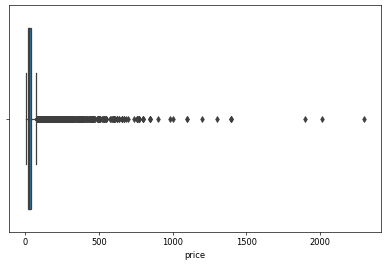

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5), dpi=60)
sns.boxplot(training_df['price'])

Lots of outliers in price that could harm our model. Let's remove

In [15]:
# price outlier removal
def outlier_removal(df):
    col = 'price'
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    price_ub = q3 + 1.5*(q3-q1)      # upper bound
    price_lb = q1 - 1.5*(q3-q1)     # lower bound
    df_new = df[df[col] < price_ub]
    print('removed outliers: ',df.shape[0]-df_new.shape[0])
    return df_new

training_df_1 = outlier_removal(training_df)

removed outliers:  7631


In [28]:
len(training_df_1)

129599

Lets create a new object feature that combines all features of interest into 1

In [35]:
all_in_one = pd.DataFrame(training_df_1['description'] +' '+ training_df_1['variety'] +' '+ training_df_1['winery'] +
              ' '+ training_df_1['province'])
all_in_one.columns = ['all_features']


In [36]:
all_in_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129599 entries, 3 to 150929
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   all_features  129599 non-null  object
dtypes: object(1)
memory usage: 2.0+ MB


In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
vec_model = vec.fit(all_in_one.all_features)
X = vec_model.transform(all_in_one.all_features)
X = X.sorted_indices()
X

<129599x36371 sparse matrix of type '<class 'numpy.float64'>'
	with 4939523 stored elements in Compressed Sparse Row format>

In [98]:
y = training_df_1['price'].values

### Modelling

In [99]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [93]:
xgr = XGBRegressor(n_estimators=400, learning_rate=0.1, 
                   # reg_lambda = 1, reg_alpha = 1, 
                    gamma=0.0, max_depth=5)
model = xgr.fit(X_train,y_train)

In [94]:
model.score(X_val,y_val)

0.537418342423345

#### DNN Model
Lets try a DNN model to see if prediction could be improved

In [103]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam

dnn_model = Sequential()
dnn_model.add(Dense(100, input_shape = (X_train.shape[1],), activation = 'relu'))
dnn_model.add(Dense(50, activation='relu'))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(1, activation='linear'))
dnn_model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.01))

In [104]:
dnn_model.fit(X_train,y_train, 
          batch_size=500, 
          validation_data= (X_val, y_val),
          epochs=30, verbose=1)

Epoch 1/30
208/208 [==============================] - 7s 32ms/step - loss: 191.6393 - val_loss: 100.3292
Epoch 2/30
208/208 [==============================] - 7s 32ms/step - loss: 109.9027 - val_loss: 86.2933
Epoch 3/30
208/208 [==============================] - 7s 31ms/step - loss: 86.8204 - val_loss: 80.0761
Epoch 4/30
208/208 [==============================] - 7s 31ms/step - loss: 72.0603 - val_loss: 75.9210
Epoch 5/30
208/208 [==============================] - 6s 31ms/step - loss: 61.5201 - val_loss: 73.6085
Epoch 6/30
208/208 [==============================] - 6s 30ms/step - loss: 54.9959 - val_loss: 71.4217
Epoch 7/30
208/208 [==============================] - 6s 31ms/step - loss: 49.4499 - val_loss: 70.2760
Epoch 8/30
208/208 [==============================] - 7s 34ms/step - loss: 44.9185 - val_loss: 69.0374
Epoch 9/30
208/208 [==============================] - 7s 34ms/step - loss: 40.6546 - val_loss: 71.8007
Epoch 10/30
208/208 [==============================] - 7s 34ms/step - 

In [105]:
 from sklearn.metrics import r2_score, matthews_corrcoef
    
y_pred1 = dnn_model.predict(X_train)
y_pred2 = dnn_model.predict(X_val)
print('training r^2: ',r2_score(y_train,y_pred1))
print('validation r^2: ',r2_score(y_val,y_pred2))

training r^2:  0.9770583724225691
validation r^2:  0.7420660495055054


#### Price Prediction

Preprocessing

In [107]:
test_feat = pd.DataFrame(test_df['description'] +' '+ test_df['variety'] +' '+ test_df['winery'] +
              ' '+ test_df['province'])
test_feat.columns = ['all_features']

In [108]:
X_test = vec_model.transform(test_feat.all_features)
X_test = X_test.sorted_indices()
X_test

<13695x36371 sparse matrix of type '<class 'numpy.float64'>'
	with 484750 stored elements in Compressed Sparse Row format>

Predict

In [115]:
price_predict = dnn_model.predict(X_test)
price_predict = price_predict.astype('int32')

Impute

In [129]:
indices = test_df.index.values

In [139]:
data_Eng1.loc[indices,'price'] = price_predict
data_Eng1.isnull().sum()

country        0
description    0
points         0
price          0
province       0
variety        0
winery         0
dtype: int64

Now we no longer have missing price data. We will proceed to task 2: Recommendation.

In [ ]:
def cubed(list):
    

In [150]:
b = [1,2,3,4,5,6,7]

c = [i**2 for i in b if i%2 == 0]
c

[4, 16, 36]

In [156]:
d = ['a','b','c']
e = [1,2,3]
f = {i:j for i,j in zip(d,e)}
f

{'a': 1, 'b': 2, 'c': 3}